<a href="https://colab.research.google.com/github/vuongtruongson99/ML_journey/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Импортировать важную библиотеку 🌟

In [1]:
!apt-get install tree
! pip install -q kaggle
!pip install -qU wandb
!pip install -qU bbox-utility

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (39.1 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155569 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.8 MB 2.1 MB/s 
     |████████████████████████████████| 158 kB 59.2 MB/s 
     |███████████████████████

In [21]:
import ast
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys

from joblib import Parallel, delayed

from IPython.display import display

# 1. Загрузить обучающий набор данных 📝

### Скачать набор данных

In [ ]:
from google.colab import files

files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c tensorflow-great-barrier-reef

100% 14.2G/14.2G [03:52<00:00, 91.6MB/s]
100% 14.2G/14.2G [03:52<00:00, 65.4MB/s]


### Распаковать данные

In [ ]:
!mkdir tensorflow-great-barrier-reef
%cd tensorflow-great-barrier-reef
!unzip /content/tensorflow-great-barrier-reef.zip

# 2. Данные анализа

### Примечание о данных:

- Как хранятся данные, есть ли папка с изображениями и CSV-файл с аннотациями?
- Как отформатирована аннотация (`yolo`, `coco`, `voc`,...)?
- Что такое метрика для расчета точности модели (F1, F2, mAP,...)?


### Загрузить файл аннотации

In [32]:
ROOT_DIR = "/content/tensorflow-great-barrier-reef/"

train_df = pd.read_csv(ROOT_DIR + 'train.csv')
train_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


### Проверьте в видео, на скольких фотографиях есть объекты

In [34]:
for video_id in train_df['video_id'].unique():
    print(f'video_id: {video_id}')
    print(f'w   annotations:  {sum(train_df[train_df["video_id"]==video_id]["annotations"] == "[]")}')
    print(f'w/o annotations:  {sum(train_df[train_df["video_id"]==video_id]["annotations"] != "[]")}\n')

video_id: 0
w   annotations:  4565
w/o annotations:  2143

video_id: 1
w   annotations:  6133
w/o annotations:  2099

video_id: 2
w   annotations:  7884
w/o annotations:  677



### Изменяем тип аннотаций с str на list

In [35]:
train_df['annotations'] = train_df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
train_df.info()

  0%|          | 0/23501 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


### Добавляем столбцы пути к изображению и количество ящиков

In [36]:
train_df['image_path'] = f'{ROOT_DIR}/train_images/video_'+train_df.video_id.astype(str) + "/" + train_df.video_frame.astype(str)+'.jpg'
train_df['num_bbox'] = train_df['annotations'].progress_apply(lambda x: len(x))
train_df.head()

  0%|          | 0/23501 [00:00<?, ?it/s]

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bbox
0,0,40258,0,0,0-0,[],/content/tensorflow-great-barrier-reef//train_...,0
1,0,40258,1,1,0-1,[],/content/tensorflow-great-barrier-reef//train_...,0
2,0,40258,2,2,0-2,[],/content/tensorflow-great-barrier-reef//train_...,0
3,0,40258,3,3,0-3,[],/content/tensorflow-great-barrier-reef//train_...,0
4,0,40258,4,4,0-4,[],/content/tensorflow-great-barrier-reef//train_...,0


In [37]:
train_df['diff_num_bboxes'] = train_df['num_bbox'].diff().fillna(0).astype(int)
train_df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bbox,diff_num_bboxes
0,0,40258,0,0,0-0,[],/content/tensorflow-great-barrier-reef//train_...,0,0
1,0,40258,1,1,0-1,[],/content/tensorflow-great-barrier-reef//train_...,0,0
2,0,40258,2,2,0-2,[],/content/tensorflow-great-barrier-reef//train_...,0,0
3,0,40258,3,3,0-3,[],/content/tensorflow-great-barrier-reef//train_...,0,0
4,0,40258,4,4,0-4,[],/content/tensorflow-great-barrier-reef//train_...,0,0


### Получить индексы с 3 или более diff_num_bboxes

In [38]:
# Get indexes with 3 or more diff_num_bboxes
indexes = train_df[abs(train_df['diff_num_bboxes'])>=3].index.values
display(train_df.iloc[indexes])

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,image_path,num_bbox,diff_num_bboxes
10667,1,8503,5515,1687,1-5515,"[{'x': 315, 'y': 670, 'width': 66, 'height': 5...",/content/tensorflow-great-barrier-reef//train_...,5,-4
12637,1,60754,9072,656,1-9072,"[{'x': 499, 'y': 567, 'width': 63, 'height': 6...",/content/tensorflow-great-barrier-reef//train_...,7,3
12738,1,60754,9173,757,1-9173,"[{'x': 460, 'y': 280, 'width': 45, 'height': 4...",/content/tensorflow-great-barrier-reef//train_...,8,-3
19265,2,22643,5363,0,2-5363,"[{'x': 701, 'y': 133, 'width': 49, 'height': 3...",/content/tensorflow-great-barrier-reef//train_...,3,3


# 3. Визуализация

In [39]:
def get_bboxes(annotations):
    """
    annotations: list of annotations
    return: bboxes as [x_min, y_min, x_max, y_max]
    """
    if len(annotations)==0:
        return []
    boxes = pd.DataFrame(annotations, columns=['x', 'y', 'width', 'height']).astype(np.int32).values
    # [x_min, y_min, w, h] -> [x_min, y_min, x_max, y_max]
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    return boxes   

def plot_img_and_bbox(img_path, annotations):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(16,10))
    if len(annotations)>0:
        bboxes = get_bboxes(annotations)
        for i, box in enumerate(bboxes):
            # pur bbox on image
            cv2.rectangle(img,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          color = (255, 0, 0),
                          thickness = 2)
            # numbering
            ax.text(box[0], box[1]-5, i+1, color='red')

    ax.set_axis_off()
    ax.imshow(img)


def zoom_bbox(img_path, annotations):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = get_bboxes(annotations)
    
    col = 7 if len(bboxes)>=7 else len(bboxes)
    row = np.ceil(len(bboxes)/7).astype(int) if len(bboxes)>7 else 1
    fig, ax = plt.subplots(row, col, figsize=(col*2, row*3))
    cnt = 0
    for i in range(row):
        
        for j in range(col):
                        
            bbox = bboxes[cnt]
            sliced_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            
            if row==1:
                ax[j].imshow(sliced_img)
                ax[j].set_title(cnt+1, color='red')
                ax[j].set_axis_off()
            else:
                ax[i,j].imshow(sliced_img)
                ax[i,j].set_title(cnt+1, color='red')
                ax[i,j].set_axis_off()
                
            cnt += 1
            
            if cnt==len(bboxes):
                break
    
        if cnt==len(bboxes):
            break      
            
    plt.show() 

In [41]:
sample_idx = 12637
sample = train_df.iloc[sample_idx]
print(sample)

video_id                                                           1
sequence                                                       60754
video_frame                                                     9072
sequence_frame                                                   656
image_id                                                      1-9072
annotations        [{'x': 499, 'y': 567, 'width': 63, 'height': 6...
image_path         /content/tensorflow-great-barrier-reef//train_...
num_bbox                                                           7
diff_num_bboxes                                                    3
Name: 12637, dtype: object


image_id: 1-9072


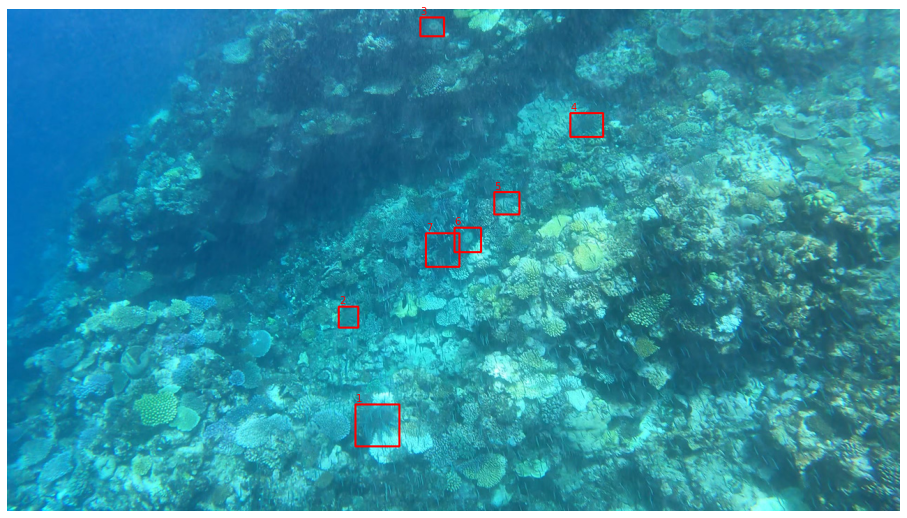

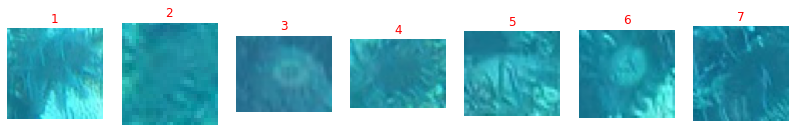

In [42]:
img_path    = sample['image_path']
annotations = sample['annotations']
print('image_id:', sample['image_id'])
# plot image with bboxes
plot_img_and_bbox(img_path, annotations)
# plot zoom of bboxes
zoom_bbox(img_path, annotations)

# 4. Создать видео

In [66]:
%cd /content

/content


In [53]:
import subprocess
from IPython.display import Video

In [44]:
WIDTH = 1280
HEIGHT = 720

In [67]:
def get_img_with_annotations(img_path, annotations):
    img = cv2.imread(img_path)
    video_id = img_path.split('/')[-2].split('_')[-1]
    frame_id = img_path.split('/')[-1].split('.')[0]
    img_id = video_id + '-' + frame_id
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if len(annotations)>0:
        bboxes = get_bboxes(annotations)
        for i, box in enumerate(bboxes):
            # put bbox
            cv2.rectangle(img,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          color = (0, 0, 255),
                          thickness = 2)
    # put image_id, #bbox
    cv2.putText(img,
                f'image_id: {img_id}, #bbox: {len(annotations)}',
                org = (30, 50), 
                color = (0, 0, 255), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1.0,
                thickness=3)
    
    return img

def make_video(df, video_id, start_frame, end_frame, fps=15, width=WIDTH, height=HEIGHT):
    '''
    df          : DataFrame
    video_id    : 0, 1, or 2
    start_frame : video_frame at start of video
    num_frame   : video_frame at end of video
    return      : path to video
    '''
    video_path = f'video_{video_id}_{start_frame}_to_{end_frame}.mp4' # video after encode
    tmp_path = 'tmp_' + video_path # video before encode (removed after encode)
    video = cv2.VideoWriter(tmp_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    df = df[df['video_id']==video_id].reset_index(drop=True)
    start_idx = df[df['video_frame']==start_frame].index[0]
    end_idx   = df[df['video_frame']==end_frame].index[0]
    df = df.iloc[start_idx:end_idx]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        image_path  = row['image_path']
        annotations = row['annotations']
        frame = get_img_with_annotations(image_path, annotations)
        video.write(frame)
    
    video.release()
    
    if os.path.exists(video_path):
        os.remove(video_path)
    
    # encode by ffmpeg command 
    subprocess.run(
        ['ffmpeg', 
         '-i', tmp_path, 
         '-loglevel', 'quiet', 
         '-crf', '18', 
         '-preset', 'veryfast', 
         '-vcodec', 'libx264', 
         video_path]
    )
    os.remove(tmp_path)
    
    return video_path

In [68]:
video_id    = sample['video_id']
start_frame = sample['video_frame'] - 100 # peek before 100 frames
end_frame   = sample['video_frame'] + 100 # peek after 100 frames
print(f'video_id: {video_id}, video_frame: {start_frame} to {end_frame}')
print('Create video ...')
video_path = make_video(train_df,
                        video_id=video_id,
                        start_frame=start_frame,
                        end_frame=end_frame)
print(video_path)

video_id: 1, video_frame: 8972 to 9172
Create video ...


  0%|          | 0/200 [00:00<?, ?it/s]

video_1_8972_to_9172.mp4


In [70]:
!ls

drive	     sample_data		    tensorflow-great-barrier-reef.zip
kaggle.json  tensorflow-great-barrier-reef  video_1_8972_to_9172.mp4


In [73]:
Video("video_1_8972_to_9172.mp4", width=WIDTH*0.7, height=HEIGHT*0.7)